# Investigation of alternative to baseline-dependent averaging.

The idea is to partition the visibility into inner and outer parts. The density of samples in the inner parts of the uv plane is much greater so we can afford to use coarser gridding but with the same field of view as used for the
further out data. The computation required for the inner, dense region of the Fourier plane is just a complex addition, instead of a complete gridding kernel complex add. This approach should rival two-region baseline-dependent averaging.

In this notebook, we investigate the consequences of imaging in this way.

In [1]:
%matplotlib inline

import os
import sys

from time import clock

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['agg.path.chunksize'] = 10000
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.convolution import Gaussian2DKernel, convolve
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt
from matplotlib.pyplot import cm 

from arl.visibility.operations import create_visibility
from arl.skymodel.operations import create_skycomponent, insert_skycomponent
from arl.image.operations import show_image, export_image_to_fits, qa_image, create_image_from_array, reproject_image
from arl.fourier_transforms.fft_support import extract_mid
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration, create_low_test_image
from arl.fourier_transforms.ftprocessor import *
from arl.visibility.compress import compress_visibility, decompress_visibility

import logging
log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Construct the SKA1-LOW configuration

In [2]:
low = create_named_configuration('LOWBD2')

To see improvement, the sampling must be sufficiently fine on the longer baselines. Hence we simulate only a very limited house angle range.

In [3]:
oversampling = 2
sampling_time = 35.0 / (oversampling * 8e4)
log.info("Critical sampling time = %.5f (radians) %.2f (seconds)" % 
         (sampling_time, sampling_time * 43200.0 / numpy.pi))
sampling_frequency = 1e8 * 35.0 / (oversampling * 8e4) 
log.info("Critical sampling frequency = %.5f (Hz) " % (sampling_frequency))
times = numpy.arange(- sampling_time, + sampling_time, sampling_time)
frequency = numpy.linspace(1e8 - sampling_frequency, 1e8 + sampling_frequency, 3)
print("Observing frequencies %s Hz" % (frequency))

Critical sampling time = 0.00022 (radians) 3.01 (seconds)
Critical sampling frequency = 21875.00000 (Hz) 
Observing frequencies [  9.99781250e+07   1.00000000e+08   1.00021875e+08] Hz


We create the visibility holding the vis, uvw, time, antenna1, antenna2, weight columns in a table. The actual visibility values are zero.

In [4]:
phasecentre = SkyCoord(ra=+180.0 * u.deg, dec=-60.0 * u.deg, frame='icrs', equinox=2000.0)
vt = create_visibility(low, times, frequency, weight=1.0, phasecentre=phasecentre, npol=1)

create_visibility: Visibility has 261632 rows, total size 0.433 GB


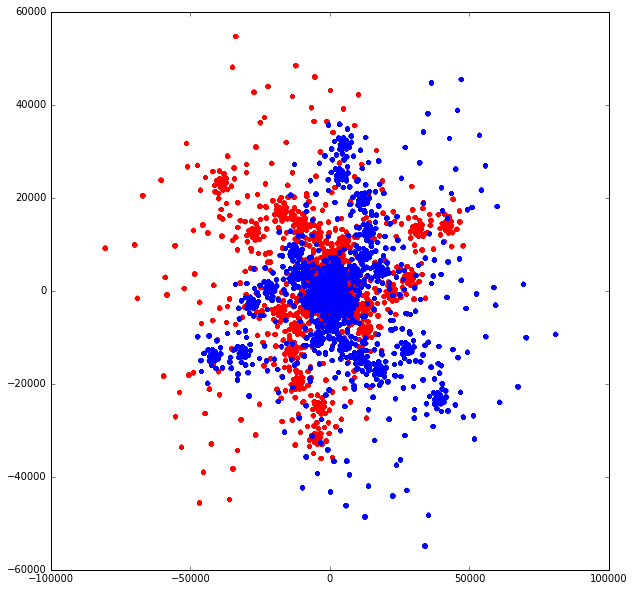

In [5]:
plt.clf()
plt.plot(+vt.u, +vt.v, '.', color='r')
plt.plot(-vt.u, -vt.v, '.', color='b')
plt.show()

Create a model to serve as the image specification

In [6]:
vt.data['vis'] *= 0.0
npixel=8192

model = create_low_test_image(npixel=npixel, cellsize=0.00001)

image.operations: created image of shape (1, 1, 8192, 8192), size 6.000 (GB)
create_low_test_image: 13139 sources inside the image


image.operations: created image of shape (8192, 8192), size 6.000 (GB)


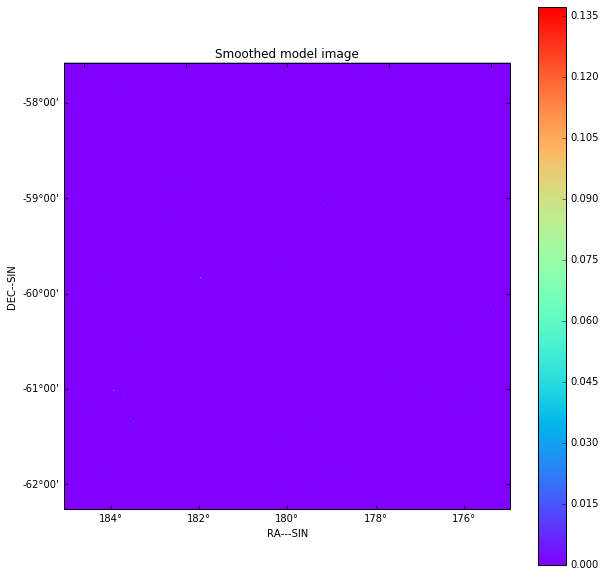

In [7]:
cmodel = create_image_from_array(convolve(model.data[0,0,:,:], Gaussian2DKernel(3.0), normalize_kernel=True), 
                                 model.wcs)
show_image(cmodel)
plt.title("Smoothed model image")
plt.show()

create_visibility_from_rows: Created view into visibility table
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining 3 channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 180., -60.)>, frequency 99978125.0 Hz, and bandwidth 21875.0 Hz
create_image_from_visibility: uvmax = 423.847578 wavelengths
create_image_from_visibility: Critical cellsize = 0.001180 radians, 0.067590 degrees
create_image_from_visibility: Cellsize          = 0.000640 radians, 0.036669 degrees
image.operations: created image of shape (3, 1, 2048, 2048), size 1.125 (GB)
get_ftprocessor_params: effective uv cellsize is 0.4 wavelengths
get_ftprocessor_params: Channel synthesis mode
weight_gridding: Performing uniform weighting


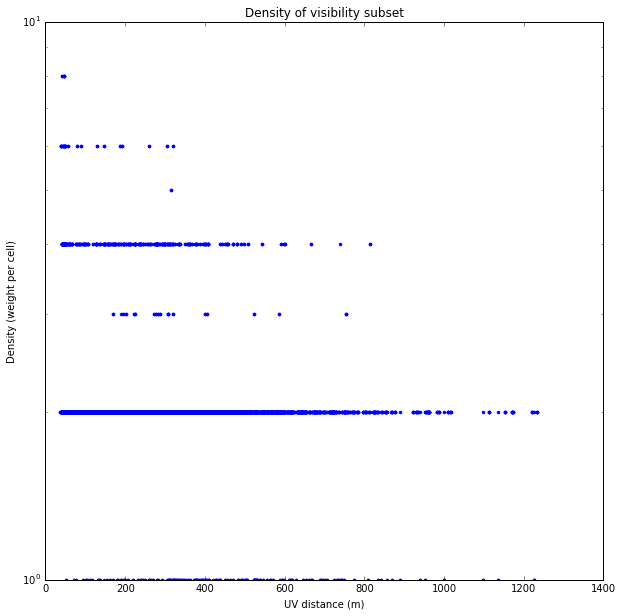

get_ftprocessor_params: effective uv cellsize is 0.4 wavelengths
get_ftprocessor_params: Channel synthesis mode
compress_visibility: Created new Visibility for compressed data
compress_visibility: Compressed 73057 visibility rows (3 channels) into 108954 rows (3 channels)


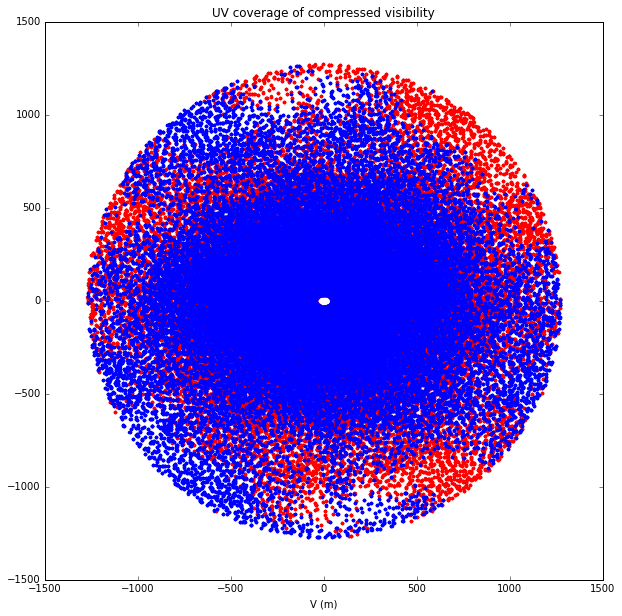

create_visibility_from_rows: Created view into visibility table
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining 3 channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 180., -60.)>, frequency 99978125.0 Hz, and bandwidth 21875.0 Hz
create_image_from_visibility: uvmax = 846.313525 wavelengths
create_image_from_visibility: Critical cellsize = 0.000591 radians, 0.033850 degrees
create_image_from_visibility: Cellsize          = 0.000320 radians, 0.018335 degrees
image.operations: created image of shape (3, 1, 2048, 2048), size 1.125 (GB)
get_ftprocessor_params: effective uv cellsize is 0.8 wavelengths
get_ftprocessor_params: Channel synthesis mode
weight_gridding: Performing uniform weighting


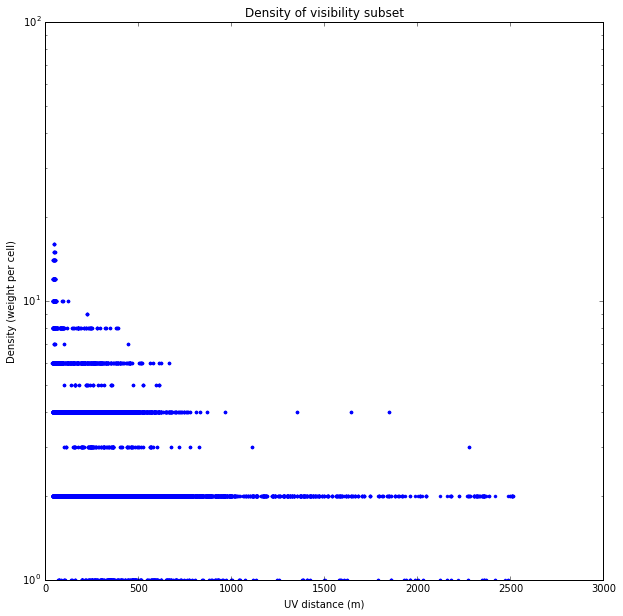

get_ftprocessor_params: effective uv cellsize is 0.8 wavelengths
get_ftprocessor_params: Channel synthesis mode
compress_visibility: Created new Visibility for compressed data
compress_visibility: Compressed 96822 visibility rows (3 channels) into 131526 rows (3 channels)


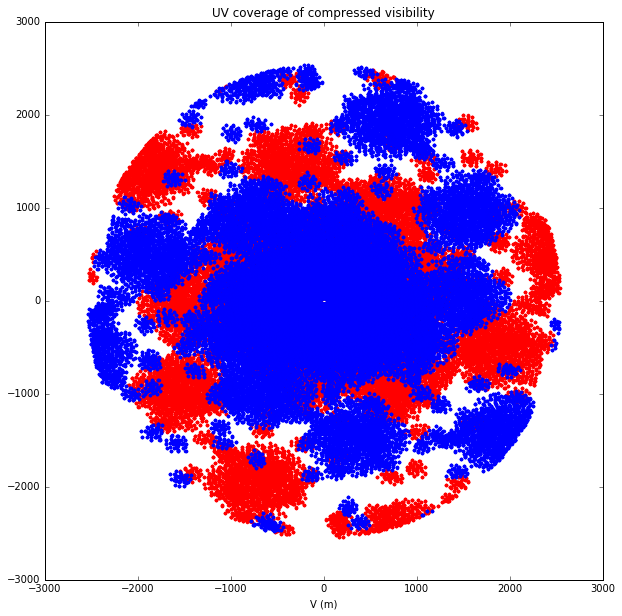

create_visibility_from_rows: Created view into visibility table
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining 3 channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 180., -60.)>, frequency 99978125.0 Hz, and bandwidth 21875.0 Hz
create_image_from_visibility: uvmax = 1690.370847 wavelengths
create_image_from_visibility: Critical cellsize = 0.000296 radians, 0.016948 degrees
create_image_from_visibility: Cellsize          = 0.000160 radians, 0.009167 degrees
image.operations: created image of shape (3, 1, 2048, 2048), size 1.125 (GB)
get_ftprocessor_params: effective uv cellsize is 1.5 wavelengths
get_ftprocessor_params: Channel synthesis mode
weight_gridding: Performing uniform weighting


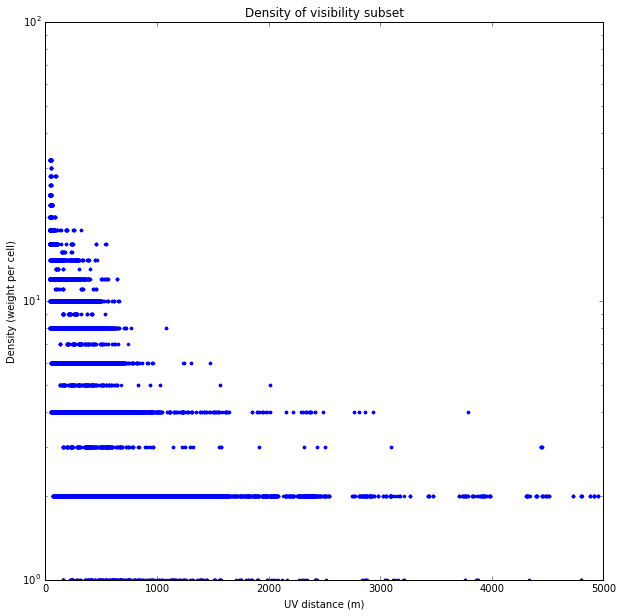

get_ftprocessor_params: effective uv cellsize is 1.5 wavelengths
get_ftprocessor_params: Channel synthesis mode
compress_visibility: Created new Visibility for compressed data
compress_visibility: Compressed 126995 visibility rows (3 channels) into 143691 rows (3 channels)


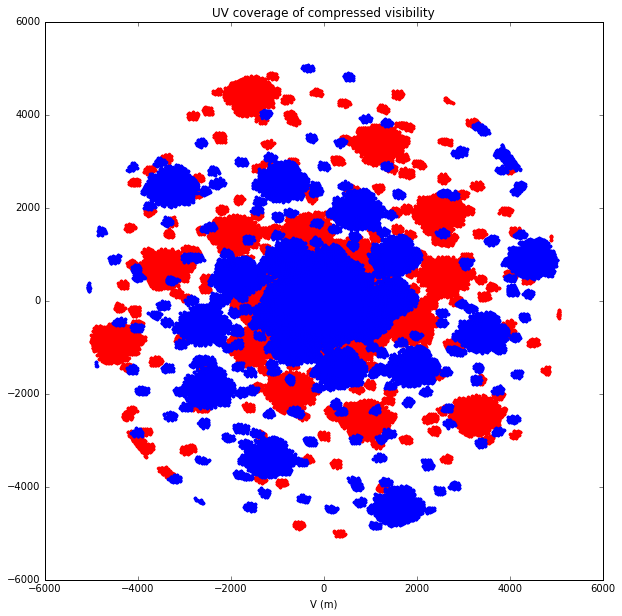

create_visibility_from_rows: Created view into visibility table
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining 3 channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 180., -60.)>, frequency 99978125.0 Hz, and bandwidth 21875.0 Hz
create_image_from_visibility: uvmax = 3372.403915 wavelengths
create_image_from_visibility: Critical cellsize = 0.000148 radians, 0.008495 degrees
create_image_from_visibility: Cellsize          = 0.000080 radians, 0.004584 degrees
image.operations: created image of shape (3, 1, 2048, 2048), size 1.125 (GB)
get_ftprocessor_params: effective uv cellsize is 3.1 wavelengths
get_ftprocessor_params: Channel synthesis mode
weight_gridding: Performing uniform weighting


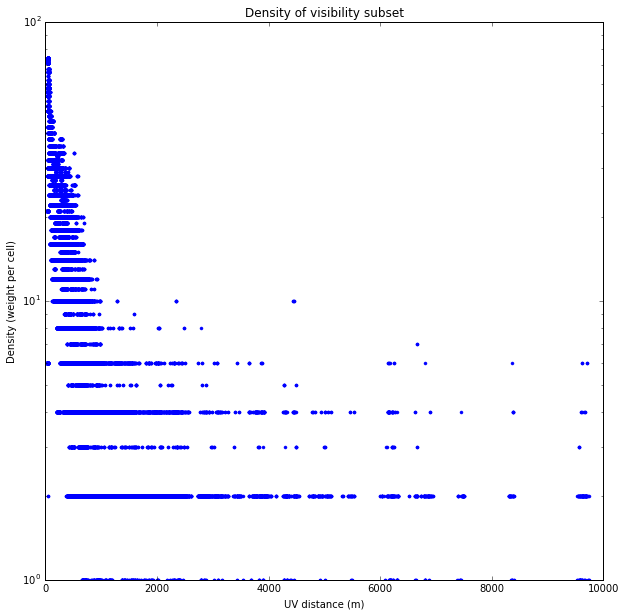

get_ftprocessor_params: effective uv cellsize is 3.1 wavelengths
get_ftprocessor_params: Channel synthesis mode
compress_visibility: Created new Visibility for compressed data
compress_visibility: Compressed 162426 visibility rows (3 channels) into 139698 rows (3 channels)


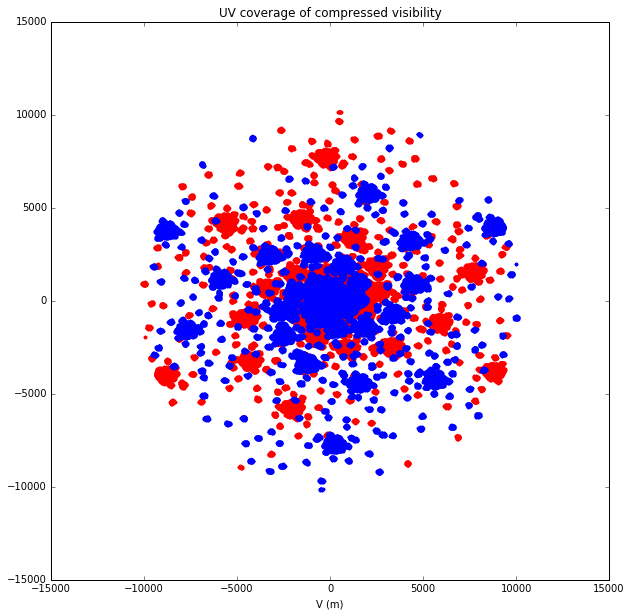

create_visibility_from_rows: Created view into visibility table
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining 3 channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 180., -60.)>, frequency 99978125.0 Hz, and bandwidth 21875.0 Hz
create_image_from_visibility: uvmax = 6712.570337 wavelengths
create_image_from_visibility: Critical cellsize = 0.000074 radians, 0.004268 degrees
create_image_from_visibility: Cellsize          = 0.000040 radians, 0.002292 degrees
image.operations: created image of shape (3, 1, 2048, 2048), size 1.125 (GB)
get_ftprocessor_params: effective uv cellsize is 6.1 wavelengths
get_ftprocessor_params: Channel synthesis mode
weight_gridding: Performing uniform weighting


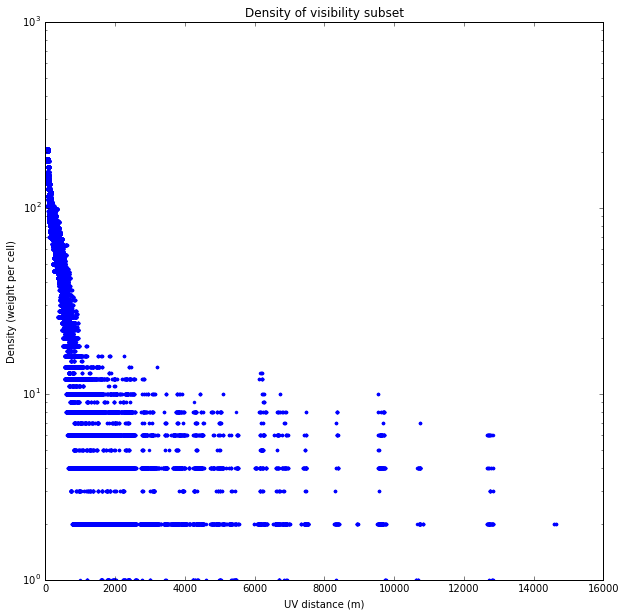

get_ftprocessor_params: effective uv cellsize is 6.1 wavelengths
get_ftprocessor_params: Channel synthesis mode
compress_visibility: Created new Visibility for compressed data
compress_visibility: Compressed 203500 visibility rows (3 channels) into 103117 rows (3 channels)


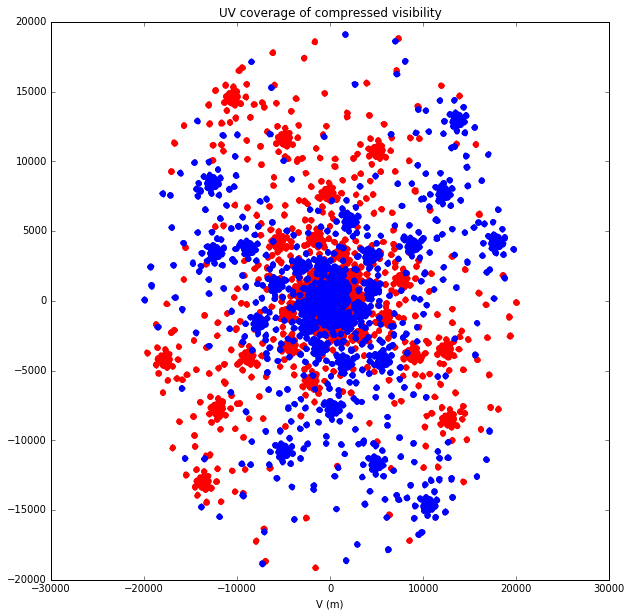

create_visibility_from_rows: Created view into visibility table
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining 3 channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 180., -60.)>, frequency 99978125.0 Hz, and bandwidth 21875.0 Hz
create_image_from_visibility: uvmax = 13271.712160 wavelengths
create_image_from_visibility: Critical cellsize = 0.000038 radians, 0.002159 degrees
create_image_from_visibility: Cellsize          = 0.000020 radians, 0.001146 degrees
image.operations: created image of shape (3, 1, 2048, 2048), size 1.125 (GB)
get_ftprocessor_params: effective uv cellsize is 12.2 wavelengths
get_ftprocessor_params: Channel synthesis mode
weight_gridding: Performing uniform weighting


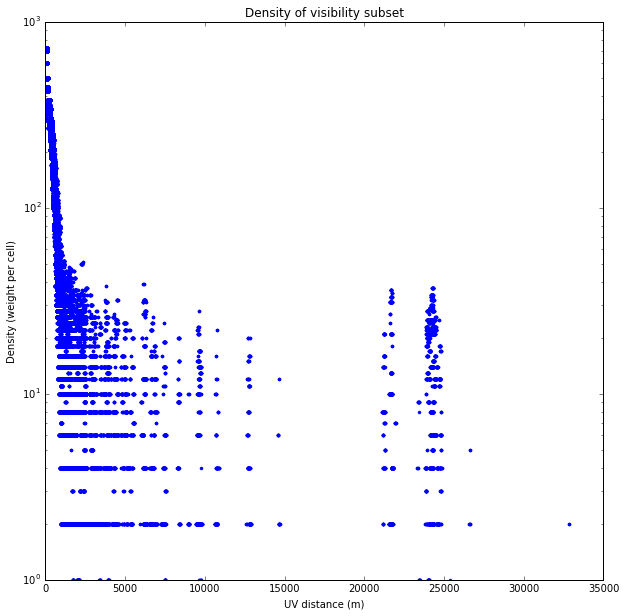

get_ftprocessor_params: effective uv cellsize is 12.2 wavelengths
get_ftprocessor_params: Channel synthesis mode
compress_visibility: Created new Visibility for compressed data
compress_visibility: Compressed 248532 visibility rows (3 channels) into 49749 rows (3 channels)


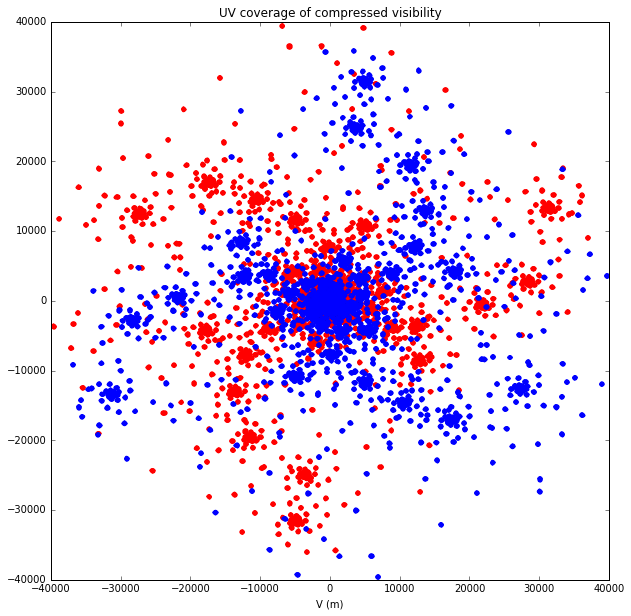

In [ ]:
inners = [1.0/64.0, 1.0/32.0, 1.0/16.0, 1.0/8.0, 1.0/4.0, 1.0/2.0]
times = []
qas = []
for boundary in inners:

    visr = numpy.sqrt(vt.u**2+vt.v**2)
    uvmax = numpy.max(visr)
    inner_rows = (numpy.abs(visr)  < boundary * uvmax) & (numpy.abs(visr) <  boundary * uvmax)
    inner_vis = create_visibility_from_rows(vt, inner_rows) 
    inner_im = create_image_from_visibility(inner_vis, npixel=2048, cellsize=0.00001/boundary)
    vts, density, densitygrid = weight_visibility(inner_vis, inner_im)
    plt.clf()
    uvdist = numpy.sqrt(vts.u*vts.u+vts.v*vts.v)
    plt.semilogy(uvdist[density[:,0,0]>0.0], density[:,0,0][density[:,0,0]>0], '.')
    plt.title('Density of visibility subset')
    plt.xlabel('UV distance (m)')
    plt.ylabel('Density (weight per cell)')
    plt.show()
    
    inner_vis_compressed = compress_visibility(inner_vis, inner_im)
    plt.clf()
    plt.title('UV coverage of compressed visibility')
    plt.plot(inner_vis_compressed.u, inner_vis_compressed.v, '.', color='r')
    plt.plot(-inner_vis_compressed.u, -inner_vis_compressed.v, '.', color='b')
    plt.xlabel('U (m)')
    plt.xlabel('V (m)')
    plt.show() 

First use invert_timeslice to get the benchmark time.

In [ ]:
model = create_image_from_visibility(vt, npixel=npixel, cellsize=0.00001, npol=1, nchan=len(frequency))

ts = clock()
full_dirty, full_sumwt = invert_2d(vt, model, dopsf=False, nprocessor=1)
full_dirty = normalize_sumwt(full_dirty, full_sumwt)

criterion = 'medianabs'
qa_full = qa_image(full_dirty).data[criterion]
t_full = clock() - ts
log.debug("Invert_2d took %.1f seconds" % (t_full))
export_image_to_fits(full_dirty, 'imaging-twopart_dirty_full.fits')

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining 3 channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 180., -60.)>, frequency 99978125.0 Hz, and bandwidth 21875.0 Hz
create_image_from_visibility: uvmax = 26976.341594 wavelengths
create_image_from_visibility: Critical cellsize = 0.000019 radians, 0.001062 degrees
create_image_from_visibility: Cellsize          = 0.000010 radians, 0.000573 degrees
image.operations: created image of shape (3, 1, 8192, 8192), size 18.000 (GB)
invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 6.1 wavelengths
get_ftprocessor_params: Channel synthesis mode


In [ ]:
def invert_twopart(vis, im, dopsf=False, invert=invert_2d, **kwargs):
    """Divide vis into inner and outer, image separately, and add
    
    Cut down on processing by gridding the inner (dense) part of Fourier plane with box gridding, 
    and the outer (sparse) part by more accurate PSWF gridding.
    """

    # Partition the visibility data
    boundary = get_parameter(kwargs, "inner", 0.125)
    visr = numpy.sqrt(vis.u*vis.u+vis.v*vis.v)
    uvmax = numpy.max(visr)
    inner_rows = (numpy.abs(visr)  < boundary * uvmax) 
    outer_rows = (numpy.abs(visr) >= boundary * uvmax)

    inner_vis = create_visibility_from_rows(vis, inner_rows)
    outer_vis = create_visibility_from_rows(vis, outer_rows)
    log.debug("Split into inner (%d rows) and outer (%d rows)" % (numpy.sum(inner_rows), numpy.sum(outer_rows)))

    # Do the outer baselines with standard parameters
    outer_params = copy.copy(kwargs)
    outer_im = create_image_from_visibility(outer_vis, **outer_params)
    outer_result, outer_sumwt = invert(outer_vis, outer_im, dopsf, **outer_params)
    outer_result.data = norm_sumwt(outer_result.data, outer_sumwt)
    
    # Compress the inner baselines by averaging onto a grid with small cellsize
    cellsize = abs(numpy.pi * im.wcs.wcs.cdelt[0] / 180.0)    
    inner_params = copy.copy(kwargs)
    inner_params['cellsize'] = cellsize / boundary  

    inner_im = create_image_from_visibility(inner_vis, **inner_params)
    inner_vis_compressed = compress_visibility(inner_vis, inner_im, **inner_params)
    
    # Now make the full scale image using only the compressed image
    inner_result, inner_sumwt = invert(inner_vis_compressed, outer_im, dopsf, **outer_params)
    inner_result.data = norm_sumwt(inner_result.data, inner_sumwt)
 
    result = create_image_from_visibility(outer_vis, **outer_params)
    result_sumwt = inner_sumwt + outer_sumwt
    nchan=result.data.shape[0]
    npol=result.data.shape[1]
    for chan in range(nchan):
        for pol in range(npol):
            result.data[chan,pol,...] = (inner_sumwt[chan, pol] * inner_result.data[chan,pol,...] + 
                                         outer_sumwt[chan, pol] * outer_result.data[chan,pol,...])
    
    return result, result_sumwt, inner_result, inner_sumwt 

Now do a range of partitions

In [ ]:
inners = [1.0/64.0, 1.0/32.0, 1.0/16.0, 1.0/8.0, 1.0/4.0, 1.0/2.0]
times = []
qas = []
for inner in inners:
    ts = clock()
    twopart_dirty, twopart_sumwt, inner_dirty, inner_sumwt = invert_twopart(vt, model, 
                                                                            dopsf=False, invert=invert_2d, 
                                                                            inner=inner, npixel=2048, 
                                                                            cellsize=0.00001)
    t_twopart = clock() - ts
    log.debug("Invert_twopart using inner=%.3f took %.1f seconds" % (inner, t_twopart))
    times.append(t_twopart)
    
    plt.clf()
    inner_dirty = normalize_sumwt(inner_dirty, inner_sumwt)
    show_image(inner_dirty)
    plt.title("Inner image for inner = %.3f" % (inner))
    plt.show()
    
    twopart_dirty.data = norm_sumwt(twopart_dirty.data, twopart_sumwt)
    export_image_to_fits(twopart_dirty, 'imaging-twopart_dirty_full%.3f.fits' % inner)   

    twopart_dirty.data-=full_dirty.data

    thisqa = qa_image(twopart_dirty)
    print(thisqa)
    qas.append(thisqa.data[criterion]) 
    
    show_image(twopart_dirty)
    plt.title("Error in dirty for inner = %.3f * uvmax" % inner)
    plt.show()

In [ ]:
print(times)
print(qas)
plt.clf()
plt.plot(inners, times, label='twopart', color='g')
plt.axhline(t_full, label='2d', color='r')
plt.xlabel('Fraction of uvmax')
plt.ylabel('Time (s)')
plt.title('Processing time as function of fractional uvmax')
plt.ylim(0.0, 1.1*t_full)
plt.legend()
plt.show()
plt.clf()
plt.plot(inners, qas, label='twopart', color='g')
plt.axhline(qa_full, label='2d', color='r')
plt.xlabel('Fraction of uvmax')
plt.ylabel('Median abs')
plt.ylim(0.0, 1.1*qa_full)

plt.legend()
plt.title('Median absolute error as function of fractional uvmax')
plt.show()

In [ ]:
ac